### Regridding data to climate grid scale
[18-09-19]

In [41]:
# Libraries
%load_ext autoreload
%autoreload

import numpy as np
import iris
import pandas as pd

import sys
sys.path.append('../')
from libs.plot_maps import *


import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy.ma as ma
%matplotlib inline
import cartopy.crs as ccrs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
# Loading in the data
dir = '../data/'
files = {'cropland'     :'states.TRENDYv8.proc.crop.n96e.nc',
         'fract_agr'    :'states.TRENDYv8.proc.frac_agr.n96e.nc',
         'pasture'      :'states.TRENDYv8.proc.pastr.n96e.nc'}


input_data = {}

for key, f in files.items():
    dat = iris.load_cube(dir + f, 'area_fraction')
    input_data[key] = dat

Need to add in the dimension coordinates for latitude and longitude, so we're going to load in a UKESM file to pinch the lat and lon dim coords from there

In [43]:
template = iris.load_cube(dir + 'canopy2000-2014.nc')

# Taking the array of the coordinates
lat = template.coord('latitude').points
lon = template.coord('longitude').points

Setting up the coordinates

In [44]:
# Dim coord for latitude (index: 1)
coord_lat = iris.coords.DimCoord(lat, standard_name='latitude',
                                 coord_system=iris.coord_systems.GeogCS(6371229.0),var_name='latitude',
                                 units='degrees')

# Dim coord for longitude (index: 2)
coord_lon = iris.coords.DimCoord(lon, standard_name='longitude',
                                 coord_system=iris.coord_systems.GeogCS(6371229.0),var_name='longitude',
                                 units='degrees')

Loading in the mask to use for regridding

In [45]:
dir_mask = '../data/climate/'
file = 'climate_mask.nc'

mask = iris.load_cube(dir_mask + file)

### Regridding the data

In [47]:
regrid_data = {}
for key in input_data.keys():
    
    # Adding dimension coordinates to data
    input_data[key].add_dim_coord(coord_lat, 1)
    input_data[key].add_dim_coord(coord_lon, 2)
    
    # Regridding the data
    regrid_data[key] = input_data[key].regrid(mask, iris.analysis.Linear())

Compare to original files

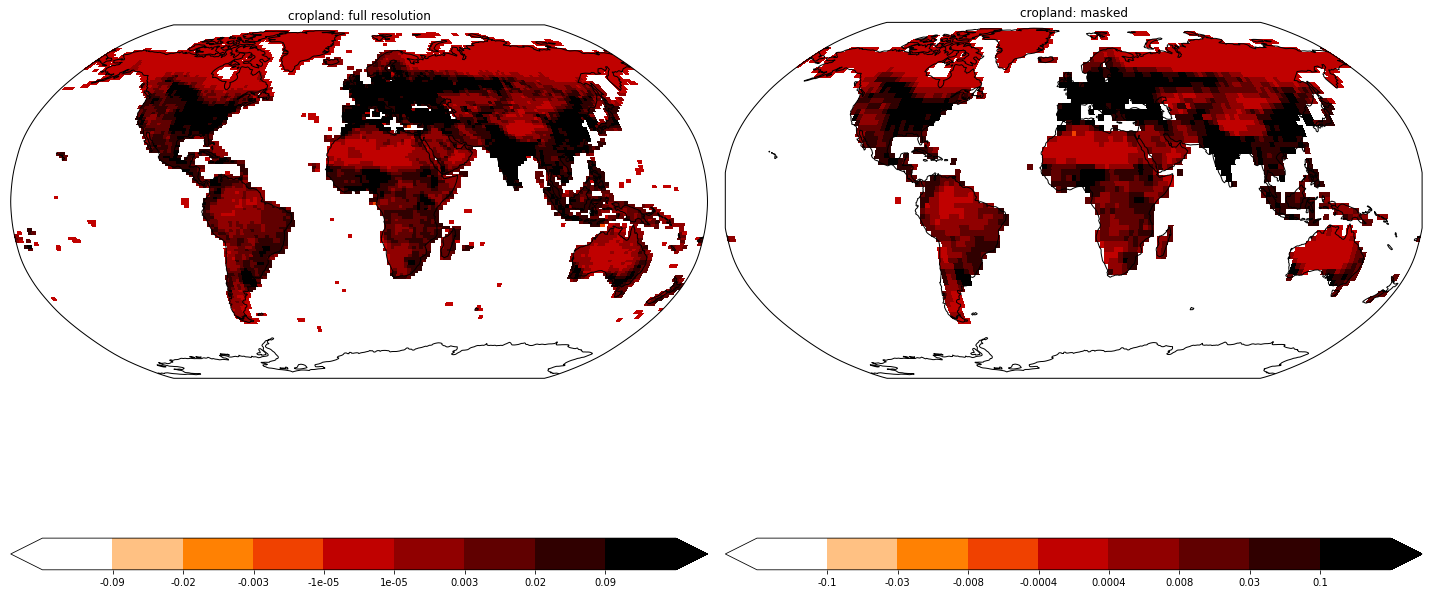

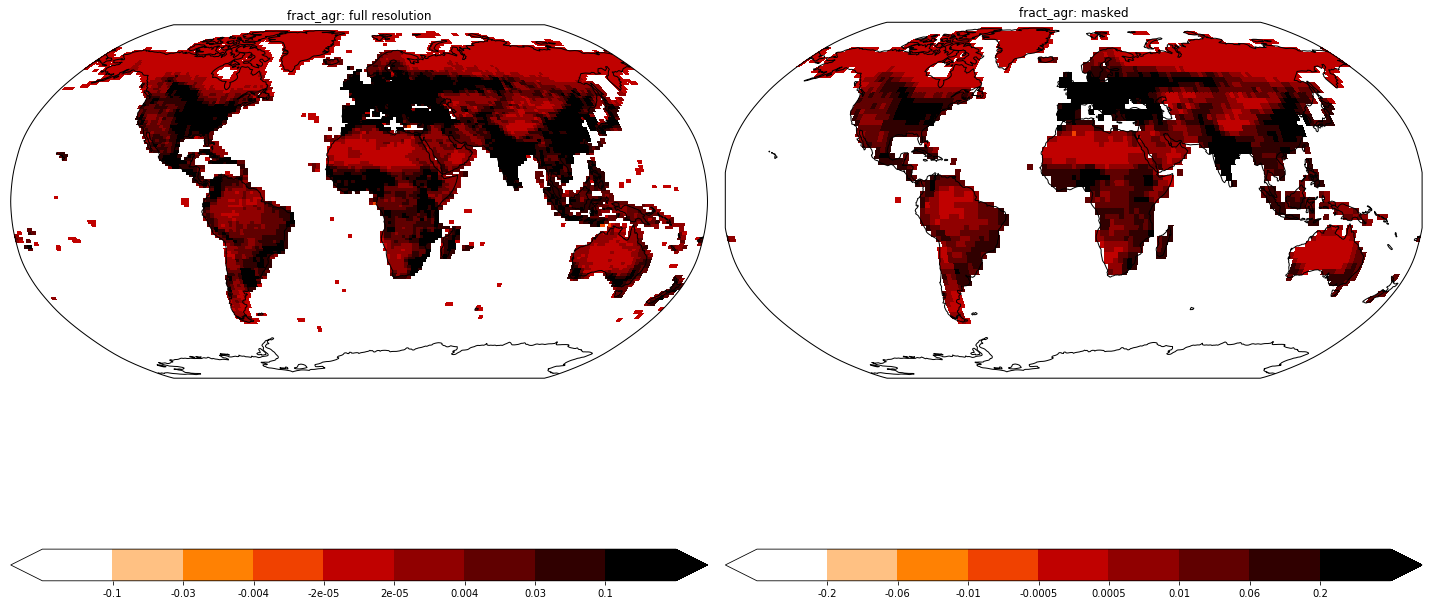

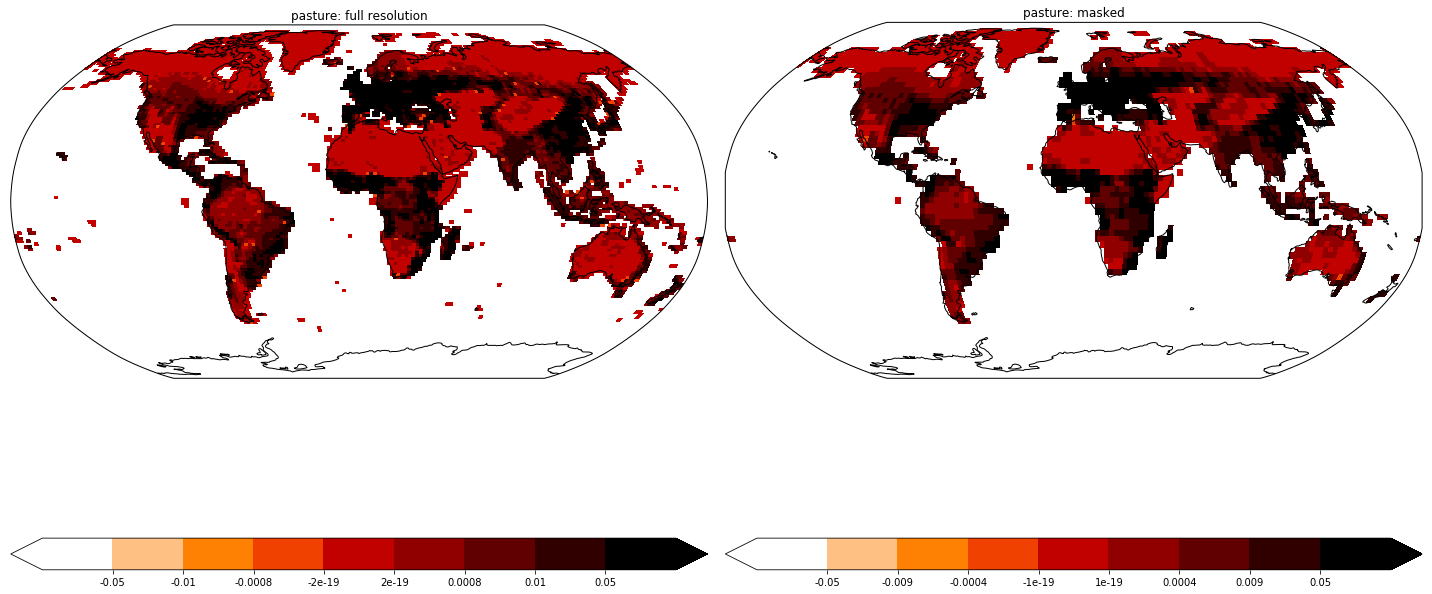

In [48]:
plt.rcParams['figure.figsize'] = [20, 45]

i = 1

for key in regrid_data.keys():
#    plt.subplot(1, 2, 1)
    dat1 = input_data[key].collapsed('time', iris.analysis.MEAN)
    plot_lonely_cube(dat1, len(regrid_data.keys()), 2, i, cmap = 'gist_heat_r', levels = None)
    plt.title('%s: full resolution' %key)
    i = i + 1
    
#    plt.subplot(1, 2, 2)
    dat2 = regrid_data[key].collapsed('time', iris.analysis.MEAN)
    plot_lonely_cube(dat2, len(regrid_data.keys()), 2, i, cmap = 'gist_heat_r', levels = None)
    plt.title('%s: masked' %key)
    plt.show()
    i = i + 1

### Save the outputs

In [51]:
for key, dat in regrid_data.items():
    new_file_names = key + "_masked.nc"
    out = '../data/land_use/' + new_file_names
    print(new_file_names)
    iris.save(dat, out)

cropland_masked.nc
fract_agr_masked.nc
pasture_masked.nc
